<a href="https://colab.research.google.com/github/Beerschtein/PyTorch/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.

2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50. 

3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

### Загрузим данные, сделаем предобработку, разделим на "test" и "train".

In [16]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [17]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

Files already downloaded and verified


In [18]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

### Датасет содержит 100 классов. Посмотрим на содержание.

In [20]:
dataset.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [21]:
dataset_classes_items = dict()

for dataset_item in dataset:
    label = dataset.classes[dataset_item[1]]
    if label not in dataset_classes_items:
        dataset_classes_items[label] = 1
    else:
        dataset_classes_items[label] += 1

dataset_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

In [22]:
classes = dataset.classes
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

torch.Size([128, 3, 32, 32])
pickup_truck


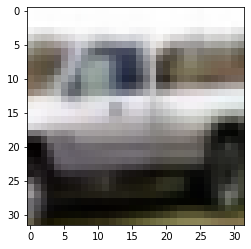

In [23]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Обучим сеть, рассмотренную на занятии, на новом датасете. Изменим последний слой для классификации на 100 объектов.

In [25]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two =torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 400)
        self.fc2 = torch.nn.Linear(400, 200)
        self.out = torch.nn.Linear(200, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=100, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [27]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 400]         192,400
          Dropout-10                  [-1, 400]               0
           Linear-11                  [-1, 200]          80,200
           Linear-12                  [-1, 100]          20,100
Total params: 375,146
Trainable params: 375,146
Non-trainable params: 0
-------------------------------

In [28]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.008
Epoch [1/5]. Step [301/372]. Loss: 0.034. Acc: 0.034. Test acc: 0.046
Epoch [2/5]. Step [1/372]. Loss: 0.033. Acc: 0.047. Test acc: 0.045
Epoch [2/5]. Step [301/372]. Loss: 0.032. Acc: 0.047. Test acc: 0.073
Epoch [3/5]. Step [1/372]. Loss: 0.031. Acc: 0.055. Test acc: 0.074
Epoch [3/5]. Step [301/372]. Loss: 0.032. Acc: 0.066. Test acc: 0.080
Epoch [4/5]. Step [1/372]. Loss: 0.032. Acc: 0.055. Test acc: 0.086
Epoch [4/5]. Step [301/372]. Loss: 0.031. Acc: 0.081. Test acc: 0.085
Epoch [5/5]. Step [1/372]. Loss: 0.029. Acc: 0.156. Test acc: 0.098
Epoch [5/5]. Step [301/372]. Loss: 0.031. Acc: 0.088. Test acc: 0.100
Training is finished!


### Сеть обучается. Потери уменьшаются, точность растет. Но для такой неглубокой сети вероятно необходимо значительно большее количество эпох для обучения.

## Предобученная сеть ResNet50

### Загрузим сеть и посмотрим на входные и выходные параметры сети.

In [29]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

### Сеть написана для классификации 1000 классов. У нас выходных классов 100. Поменяем выходные параметры последнего слоя.

In [31]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [32]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [33]:
resnet50 = resnet50.to(device)

In [34]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [36]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
from torchvision.models.resnet import ResNet50_Weights
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.016. Test acc: 0.008
Epoch [1/5]. Step [301/372]. Loss: 0.020. Acc: 0.395. Test acc: 0.502
Epoch [2/5]. Step [1/372]. Loss: 0.015. Acc: 0.492. Test acc: 0.506
Epoch [2/5]. Step [301/372]. Loss: 0.013. Acc: 0.537. Test acc: 0.561
Epoch [3/5]. Step [1/372]. Loss: 0.014. Acc: 0.523. Test acc: 0.539
Epoch [3/5]. Step [301/372]. Loss: 0.012. Acc: 0.567. Test acc: 0.551
Epoch [4/5]. Step [1/372]. Loss: 0.012. Acc: 0.602. Test acc: 0.541
Epoch [4/5]. Step [301/372]. Loss: 0.012. Acc: 0.578. Test acc: 0.560
Epoch [5/5]. Step [1/372]. Loss: 0.011. Acc: 0.602. Test acc: 0.560
Epoch [5/5]. Step [301/372]. Loss: 0.012. Acc: 0.590. Test acc: 0.570
Training is finished!


### При одинаковом количевте эпох, на одних и тех же данных, эта сеть показывает результаты существенно лучше, чем предыдущая сеть.

## Аугментация данных

### Добавим в сеть ResNet50 аугментацию данных. Применим большую часть из возможных методов.

In [38]:
# #  добавил
# def train_valid_split(Xt):
#     X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
#     return X_train, X_test

In [39]:
train_actions_aug = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    # transforms.RandomCrop((100, 300)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    # transforms.RandomResizedCrop((200, 300)),
                                    transforms.ColorJitter(brightness=(0, 36), contrast=(0, 10), saturation=(0, 25), hue=(-0.5, 0.5)),
                                    transforms.RandomRotation(30, resample=Image.BICUBIC, expand=False, center=(100, 300)),
                                    # transforms.RandomAffine(degrees=30, translate=(0, 0.2), scale=(0.9, 1), shear=(6, 9), fillcolor=66),
                                    # transforms.Grayscale(num_output_channels=3),
                                    # transforms.RandomPerspective(distortion_scale=1, p=1, interpolation=3),
                                    transforms.RandomGrayscale(p=0.6), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms_aug = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset_aug, valid_dataset_aug = train_valid_split(dataset)

train_dataset_aug = MyOwnCifar(train_dataset_aug, train_actions_aug)
valid_dataset_aug = MyOwnCifar(valid_dataset_aug, valid_transforms_aug)

In [40]:
train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader_aug = torch.utils.data.DataLoader(valid_dataset_aug,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [43]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [44]:
# from torchvision.models.resnet import ResNet50_Weights
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss_aug, running_items_aug, running_right_aug = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader_aug):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss_aug += loss.item()
        running_items_aug += len(labels)
        running_right_aug += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader_aug)}]. ' \
                  f'Loss: {running_loss_aug / running_items_aug:.3f}. ' \
                  f'Acc: {running_right_aug / running_items_aug:.3f}', end='. ')
            running_loss_aug, running_items_aug, running_right_aug = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader_aug):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.047. Acc: 0.031. Test acc: 0.570
Epoch [1/5]. Step [301/372]. Loss: 0.040. Acc: 0.034. Test acc: 0.195
Epoch [2/5]. Step [1/372]. Loss: 0.038. Acc: 0.023. Test acc: 0.188
Epoch [2/5]. Step [301/372]. Loss: 0.036. Acc: 0.046. Test acc: 0.179
Epoch [3/5]. Step [1/372]. Loss: 0.036. Acc: 0.039. Test acc: 0.173
Epoch [3/5]. Step [301/372]. Loss: 0.035. Acc: 0.052. Test acc: 0.179
Epoch [4/5]. Step [1/372]. Loss: 0.034. Acc: 0.086. Test acc: 0.162
Epoch [4/5]. Step [301/372]. Loss: 0.035. Acc: 0.055. Test acc: 0.155
Epoch [5/5]. Step [1/372]. Loss: 0.034. Acc: 0.047. Test acc: 0.151
Epoch [5/5]. Step [301/372]. Loss: 0.035. Acc: 0.058. Test acc: 0.161
Training is finished!


### Упссс!!!. Все работает, но точность упала. Либо я "перестарался", либо такие трансформации для сети не годятся... Пока не разобрался в чем причина.